# Libraries

In [1]:
import numpy as np
import xarray as xr
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import requests
import h5py

# Classes and Functions

## get_surface_area function

In [4]:
def get_surface_area(nlon, nlat, lat_in=None):
    """Calculates the surface area of gridboxes in m^2

    Args:
        nlon (int): number of longitude gridboxes
        nlat (int): number of latitude gridboxes
        lat_in (float array, optional): [nlon, nlat+1] if grid is non-standard, add latitude grid edges in here. Note these are NOT the grid centres. Defaults to None.

    Raises:
        ValueError: if no lat_in is given for non-standard grid

    Returns:
        surf (float array): [nlon, nlat] array of gridbox surface areas in m^2 
    """

    if lat_in is None:
        if (nlon,nlat) == (720,360):
            lat_in = np.linspace(-90, 90, 361)
        elif (nlon,nlat) == (360,180): # 1x1 degree grid (like GFED4s pre-2000)
            lat_in = np.linspace(-90, 90, 181)
        elif (nlon,nlat) == (1440,720): # 0.25x0.25 degree grid (like GFED)
            lat_in = np.linspace(-90, 90, 721)
        elif (nlon,nlat) == (3600,1800): # 0.1x0.1 degree grid (like GFAS)
            lat_in = np.linspace(-90, 90, 1801)
        else:
            raise ValueError("ERROR: NON-STANDARD NLON OR NLAT")
    
    R_Earth = 6_371_229 # m
    pi = np.pi
    
    delta_lat = np.sin(lat_in[1:]*pi/180) - np.sin(lat_in[:-1]*pi/180) # all but the first lat minus all but the last
    surf = (delta_lat * R_Earth**2 * 2 * pi / nlon)[np.newaxis, :]  # Make delta_lat 2D
    surf = np.tile(surf, (nlon, 1))  # Repeat for all longitudes

    return surf

## Inventory parent class

In [2]:
class Inventory: # NOTE you shouldn't need to mess about with this class (apart from the path location), but feel free to have a look at the fucntions and what they do
    def __init__(self, name:str, version:str, res:float, species:str) -> None:
        self.name = name
        self.version = version
        self.res = res
        self.species = species
        self.SPECIES = species.upper()
        self.data = None
        self.load_dir = f"" # NOTE the path location of your data, which you will need to specify yourself
        self.masked_data = xr.Dataset()


    def get_datelist(self, start_date:date, end_date:date, type="monthly"):
        """Generate a list of dates between start_date and end_date, with specified frequency

        Args:
            start_date (date): date to start list
            end_date (date): date to end list
            type (str, optional): frequency of date generation. Options of "daily", "monthly", "yearly". Defaults to "monthly".

        Returns:
            list: list of tuples containing dates in format (year, month) or (year, month, day), or a list of years
        """
        
        datelist = []

        if type == "monthly":
            current_date = start_date.replace(day=1)
            end_date += relativedelta(months=1)
            end_date = end_date.replace(day=1)
            
            while current_date < end_date:
                datelist.append((current_date.strftime("%Y"), current_date.strftime("%m")))
                if current_date.month == 12:
                    current_date = current_date.replace(year=current_date.year + 1, month=1)
                else:
                    current_date = current_date.replace(month=current_date.month + 1)
        
        elif type == "daily":
            delta = end_date - start_date
            for i in range(delta.days + 1):
                date = start_date + timedelta(days=i)
                datelist.append((date.strftime("%Y"), date.strftime("%m"), date.strftime("%d")))
        
        elif type == "yearly":
            current_date = start_date.replace(day=1, month=1)
            end_date = end_date.replace(day=1, month=1, year=end_date.year + 1)
            while current_date < end_date:
                datelist.append(current_date.strftime("%Y"))
                current_date = current_date.replace(year=current_date.year + 1)
        
        return datelist
    

    def download_file(self, url:str, file_path:str):
        """Generic function to download a file. Called by download_data functions.

        Args:
            url (str): url of file to download
            file_path (str): path to save file to

        Raises:
            ValueError: if file doesn't exist so an HTML page is returned
        """
        try:
            response = requests.get(url, stream=True)
            
            response.raise_for_status()  # Raises error for 4xx and 5xx responses
            if "text/html" in response.headers.get("Content-Type", ""):
                raise ValueError("Unexpected HTML content received instead of a file.")

            with open(file_path, "wb") as file:
                file.write(response.content)
            
            print(f"{self.name}{self.version} file downloaded successfully to {file_path}")
        
        except requests.exceptions.RequestException as req_err:
            print(f"Error downloading file: {req_err}")
        except ValueError as val_err:
            print(f"Invalid file content: {val_err}")
        except FileNotFoundError:
            print(f"Error: Directory does not exist for file path {file_path}")
        except Exception as e:
            print(f"Error downloading file: {e}")


    def add_surface_area(self):
        """Calculates surface area of gridboxes and adds it to the xarray dataset.
        """
        assert self.data is not None, "Data is not loaded."
        if "surface_area" in self.data.data_vars.keys():
            print("Overwriting current surface area data")
        gridarea = get_surface_area(len(self.data["lon"]), len(self.data["lat"]))
        self.data["surface_area"] = (("lat", "lon"), gridarea.T)
        self.data["surface_area"].attrs['units'] = 'm^2'
        self.data["surface_area"].attrs['long_name'] = 'surface area of gridboxes'
        print("Surface area added to data")

## GFED4s child class

In [3]:
class GFED4s(Inventory):
    def __init__(self, res:float, species:str) -> None:
        super().__init__("GFED", "4.1s", res, species)
        self.months = '01','02','03','04','05','06','07','08','09','10','11','12'
        self.sources = 'SAVA','BORF','TEMF','DEFO','PEAT','AGRI'
        self.download_url = "https://www.geo.vu.nl/~gwerf/GFED/GFED4" #NOTE if you want to manually download you can find it here, but you can also use the download_data function to download it directly from the website (but make sure to specify the correct path location in the load_dir variable in the Inventory class)
        self.extension = "hdf5"
        self.EF = None
        if self.res < 0.25:
            raise ValueError("Resolution must be >= 0.25 degrees for GFED4s data")


    def download_data(self, start_date:date, end_date:date):
        dates = self.get_datelist(start_date, end_date, type="yearly")

        for year in dates:
            if int(year) >= 2017:
                filename = f"{self.name}{self.version}_{year}_beta.{self.extension}"
            else:
                filename = f"{self.name}{self.version}_{year}.{self.extension}"
            
            url = f"{self.download_url}/{filename}"
            file_path = f"{self.load_dir}/{filename}"
            self.download_file(url, file_path)


    def read_EFs(self):
        """Read in emission factor for specified species

        Returns:
            numpy_array: [6,] emission factors for the specified species split by source
        
        Raises:
            Exception: if species is not currently supported
        """
        

        species_dict = {
            "DM":   0,
            "c":    1,
            "co2":  2,
            "co":   3,
            "ch4":  4,
            "nmhc": 5,
            "h2":   6,
            "nox":  7,
            "n2o":  8,
            "pm2.5":9,
                        }

        if self.species not in species_dict.keys():
            raise Exception("Species not found in species dict, update code to read in emission factor for this species")


        species = [] # names of the different gas and aerosol species
        EFs     = np.zeros((41, 6)) # 41 species, 6 sources

        k = 0
        f = open(f"{self.load_dir}/GFED4_Emission_Factors.txt")
        while 1:
            line = f.readline()
            if line == "":
                break
                
            if line[0] != '#':
                contents = line.split()
                species.append(contents[0])
                EFs[k,:] = contents[1:]
                k += 1
                        
        f.close()

        return EFs[species_dict[self.species],:]


    def calculate_flux(self, year:int):
        """Calculate daily CO fluxes for a given year from GFED4.1s data

        Args:
            year (int): specified year

        Returns:
            numpy_array: [nlat, nlon, days_in_year] daily CO fluxes for the specified year
        """
        
        if self.EF is None:
            self.EF = self.read_EFs()

        # shape of data
        days_in_year = 366 if year % 4 == 0 else 365
        nlat = 180/self.res
        nlon = 360/self.res

        if int(year) >= 2017:
            file_name = f"{self.load_dir}/GFED4.1s_{year}_beta.hdf5"
        else:
            file_name = f"{self.load_dir}/GFED4.1s_{year}.hdf5"

        
        
        with h5py.File(file_name, 'r') as file: # NOTE I've called all these fluxes CO_fluxes but you should rename these variables as you won't be using CO!

            day_index = 0
            CO_flux = np.zeros((nlat, nlon, days_in_year)) # NOTE: you'll want something like (nlat, nlon, months_in_year, sources)
            
            for month in self.months:
                CO_flux_2D = np.zeros((nlat, nlon)) # NOTE if including separate sources add another dimension here

                # read in DM emissions for month
                DM_emissions_dir = f"/emissions/{month}/DM"
                DM_emissions = file[DM_emissions_dir][:]

                # read in the daily_fraction values for month
                root_str = f"emissions/{month}/daily_fraction" #NOTE you won't need daily fraction stuff for monthly emissions
                start_day = day_index
                num_days = len(file[root_str])
                daily_fraction = np.zeros((nlat, nlon, num_days))
                for day in range(num_days):
                    string = f"{root_str}/day_{day+1}"
                    daily_fraction[:,:,day] = file[string][:]
                    day_index += 1

                for source, source_index in enumerate(self.sources):
                    # read in the fractional contribution of each source
                    source_emissions_dir = f"/emissions/{month}/partitioning/DM_{source}"
                    contribution = file[source_emissions_dir][:]
                    
                    # calculate CO emissions as the product of DM emissions (kg DM per 
                    # m2 per month), the fraction the specific source contributes to 
                    # this (unitless), and the emission factor (g CO per kg DM burned)
                    CO_flux_2D += DM_emissions * contribution * self.EF[source_index] # NOTE instead of cummulatively adding sources you'll want to store them in a separate dimension
                
                # NOTE instead of this bit sorting out daily fractions, you'll want to add your flux to the relevant month in your output array
                CO_flux[:,:,start_day:day_index] = np.repeat(CO_flux_2D[:, :, np.newaxis], num_days, axis=2)
                CO_flux[:,:,start_day:day_index] *= daily_fraction[:,:,:]
        
        return CO_flux


    def extract_coordinates(self, year:int):
        
        if int(year) >= 2017:
            file_name = f"{self.load_dir}/GFED4.1s_{year}_beta.hdf5"
        else:
            file_name = f"{self.load_dir}/GFED4.1s_{year}.hdf5"
        file = h5py.File(file_name, 'r')

        lat = file["lat"][:,0]
        lon = file["lon"][0,:]
        time = [datetime(year, 1, 1) + timedelta(days=i) for i in range(366 if year % 4 == 0 else 365)] # NOTE you won't want daily time coordinates
        
        return lat, lon, time


    def process_data(self, year):
        CO_flux = self.calculate_flux(year)
        lat, lon, time = self.extract_coordinates(year)

        self.data = xr.Dataset(
            {f"{self.SPECIES}": (["lat", "lon", "time"], CO_flux)}, # NOTE you'll need to change dimensions to lat, lon, month, source
            coords={"lon": lon, "lat": lat, "time": time}
        )

        # standardise coordinates
        self.data = self.data.isel(lat=slice(None, None, -1))
        self.data.coords["lon"] = (self.data.coords["lon"] + 360) % 360
        self.data = self.data.sortby("lon")

        # standardise name and units of emissions
        self.data[f"{self.SPECIES}"] = self.data[f"{self.SPECIES}"] / (60*60*24)
        self.data[f"{self.SPECIES}"].attrs['units'] = 'g m^-2 s^-1' # NOTE I've converted from g m^-2 day^-1 to g m^-2 s^-1 here, both are not abolute units (e.g. grams) so you need to consider the effect of area when summing
        self.data[f"{self.SPECIES}"].attrs['long_name'] = f'{self.name}{self.version} emissions of {self.SPECIES}'

        print(f"{self.name}{self.version} {year} loaded and standardised")

# Code

Create the inventory:

In [ ]:
inventory = GFED4s(res=0.25, species="pm2.5") # NOTE make sure the resolution is correct!

Downloading data (multiple years)

In [ ]:
start_date = date(2002,1,1) # NOTE make sure not to mix years with different resolutions
end_date = date(2023,12,31)
inventory.download_data(start_date, end_date)

Processing one year and viewing xarray result:

In [ ]:
inventory.process_data(2012) # NOTE you can only process one year at a time becuase you can only have one year of data saved at a time
inventory.data

Process mutliple years (with same resolution)

In [ ]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

for year in years:
    inventory.process_data(year)
    inventory.add_surface_area()
    inventory.data.to_netcdf(f"{inventory.load_dir}/GFED4.1s_{year}_processed.nc") # NOTE you need to save the data as separate yearly files

# Examples

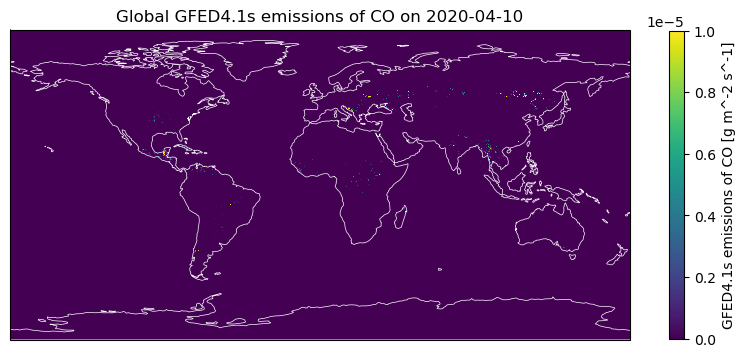

In [ ]:
plot_xarray(GFED4s_2020.data.CO.isel(time=100), vmin=0, vmax=0.00001) # NOTE this is an example plot I made using my own custom plotting function, you should work out how to plot data using more basic functions

In [ ]:
ds = GFED4s_2020.data.sel(lat=slice(-10, 10)) # example of slicing
ds

<xarray.Dataset> Size: 337MB
Dimensions:  (lat: 80, lon: 1440, time: 366)
Coordinates:
  * lat      (lat) float32 320B -9.875 -9.625 -9.375 ... 9.375 9.625 9.875
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    CO       (lat, lon, time) float64 337MB 0.0 0.0 0.0 ... 9.288e-07 3.096e-07